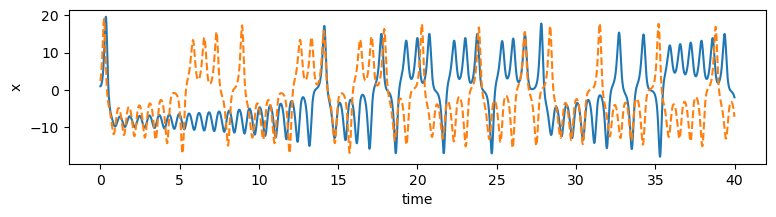

In [82]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

x_train = odeint(f, state0, time_steps)

from scipy import sparse

radius = 0.6
sparsity = 0.01
input_dim = 3
reservoir_size = 1000
n_steps_prerun = 10
regularization = 1e-2
sequence = x_train

6.52
0.01
3
1000
10
5.93

bestSet = [0.6, 0.01, 3, 1000, 10, 1e-2]

weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

weights_input = np.zeros((reservoir_size, input_dim))
q = int(reservoir_size / input_dim)
for i in range(0, input_dim):
    weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

weights_output = np.zeros((input_dim, reservoir_size))


def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
    hidden = np.zeros((reservoir_size, 1))
    for t in range(n_steps_prerun):
        input = sequence[t].reshape(-1, 1)
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    return hidden

def augment_hidden(hidden):
    h_aug = hidden.copy()
    h_aug[::2] = pow(h_aug[::2], 2.0)
    return h_aug

hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
hidden_states = []
targets = []

for t in range(n_steps_prerun, len(sequence) - 1):
    input = np.reshape(sequence[t], (-1, 1))
    target = np.reshape(sequence[t + 1], (-1, 1))
    hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
    hidden = augment_hidden(hidden)
    hidden_states.append(hidden)
    targets.append(target)

targets = np.squeeze(np.array(targets))
hidden_states = np.squeeze(np.array(hidden_states))

weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

def predict(sequence, n_steps_predict):
    hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
    input = sequence[n_steps_prerun].reshape((-1, 1))
    outputs = []

    for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
        hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
        hidden = augment_hidden(hidden)
        output = weights_output @ hidden
        input = output
        outputs.append(output)
    return np.array(outputs), hidden

x_sim, H = predict(sequence, 4000)

def plot_dimension(x_train, x_sim, dim, name):
    fig = plt.figure(figsize=(9,2))
    ax = fig.gca()
    ax.plot(time_steps, x_train[:, dim])
    ax.plot(time_steps, x_sim[:, dim], "--")
    plt.xlabel("time")
    plt.ylabel(name)

plot_dimension(x_train, x_sim, 0, 'x')

In [83]:
def rmse(x_train, x_sim, dim=0):
        res = 0
        for i in range(len(x_sim[:, dim])):
            res = res + (x_sim[:, dim][i] - x_train[:, dim][i])**2
        res = math.sqrt(res/len(x_sim[:, dim]))
        return res

bestrmse = rmse(x_train, x_sim)
print('RMSE = ', bestrmse)

RMSE =  10.939309853472176


C:\Users\nicks\AppData\Local\Temp\ipykernel_19792\1167830809.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim[:, dim]))


In [84]:
def hyperparametric_optimization(bestSet, N=10, step=0.02, bestrmse=10.024377441250149):
    
    for j in range(N):

        radius = 0.6 + ((-1)**j)*step*j
        sparsity = 0.01 
        input_dim = 3
        reservoir_size = 1000
        n_steps_prerun = 10
        regularization = 1e-2 + ((-1)**j)*step*j

        weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
        eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
        weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

        weights_input = np.zeros((reservoir_size, input_dim))
        q = int(reservoir_size / input_dim)
        for i in range(0, input_dim):
            weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

        weights_output = np.zeros((input_dim, reservoir_size))


        def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
            hidden = np.zeros((reservoir_size, 1))
            for t in range(n_steps_prerun):
                input = sequence[t].reshape(-1, 1)
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            return hidden

        def augment_hidden(hidden):
            h_aug = hidden.copy()
            h_aug[::2] = pow(h_aug[::2], 2.0)
            return h_aug

        hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
        hidden_states = []
        targets = []

        for t in range(n_steps_prerun, len(sequence) - 1):
            input = np.reshape(sequence[t], (-1, 1))
            target = np.reshape(sequence[t + 1], (-1, 1))
            hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            hidden = augment_hidden(hidden)
            hidden_states.append(hidden)
            targets.append(target)

        targets = np.squeeze(np.array(targets))
        hidden_states = np.squeeze(np.array(hidden_states))

        weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

        def predict(sequence, n_steps_predict):
            hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
            input = sequence[n_steps_prerun].reshape((-1, 1))
            outputs = []

            for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
                hidden = augment_hidden(hidden)
                output = weights_output @ hidden
                input = output
                outputs.append(output)
            return np.array(outputs), hidden

        x_sim, H = predict(sequence, 4000)
        rmsei = rmse(x_train, x_sim)
        
        if(bestrmse > rmsei):
            bestSet = [radius, sparsity, input_dim, reservoir_size, n_steps_prerun, regularization]
            bestrmse = rmsei

    for k in range(6):
        print(bestSet[k])
    print(bestrmse)

In [88]:
hyperparametric_optimization(bestSet = bestSet, N=50)

C:\Users\nicks\AppData\Local\Temp\ipykernel_19792\1167830809.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim[:, dim]))


-0.06000000000000005
0.01
3
1000
10
-0.65
8.640884718628962


In [89]:
def hyperparametric_optimization0(bestSet, N=10, step=0.02, bestrmse=10.024377441250149):
    
    for j in range(N):

        radius = 0.6 + ((1)**j)*step*j
        sparsity = 0.01 
        input_dim = 3
        reservoir_size = 1000
        n_steps_prerun = 10
        regularization = 1e-2 + ((1)**j)*step*j

        weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
        eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
        weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

        weights_input = np.zeros((reservoir_size, input_dim))
        q = int(reservoir_size / input_dim)
        for i in range(0, input_dim):
            weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

        weights_output = np.zeros((input_dim, reservoir_size))


        def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
            hidden = np.zeros((reservoir_size, 1))
            for t in range(n_steps_prerun):
                input = sequence[t].reshape(-1, 1)
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            return hidden

        def augment_hidden(hidden):
            h_aug = hidden.copy()
            h_aug[::2] = pow(h_aug[::2], 2.0)
            return h_aug

        hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
        hidden_states = []
        targets = []

        for t in range(n_steps_prerun, len(sequence) - 1):
            input = np.reshape(sequence[t], (-1, 1))
            target = np.reshape(sequence[t + 1], (-1, 1))
            hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            hidden = augment_hidden(hidden)
            hidden_states.append(hidden)
            targets.append(target)

        targets = np.squeeze(np.array(targets))
        hidden_states = np.squeeze(np.array(hidden_states))

        weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

        def predict(sequence, n_steps_predict):
            hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
            input = sequence[n_steps_prerun].reshape((-1, 1))
            outputs = []

            for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
                hidden = augment_hidden(hidden)
                output = weights_output @ hidden
                input = output
                outputs.append(output)
            return np.array(outputs), hidden

        x_sim, H = predict(sequence, 4000)
        rmsei = rmse(x_train, x_sim)
        
        if(bestrmse > rmsei):
            bestSet = [radius, sparsity, input_dim, reservoir_size, n_steps_prerun, regularization]
            bestrmse = rmsei

    for k in range(6):
        print(bestSet[k])
    print(bestrmse)

In [90]:
hyperparametric_optimization0(bestSet = bestSet, N=50)

C:\Users\nicks\AppData\Local\Temp\ipykernel_19792\1167830809.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim[:, dim]))


0.62
0.01
3
1000
10
0.03
9.271247815779894


In [91]:
def hyperparametric_optimization1(bestSet, N=10, step=0.02, bestrmse=10.024377441250149):
    
    for j in range(N):

        radius = 0.6 + ((1)**j)*step*j
        sparsity = 0.01 
        input_dim = 3
        reservoir_size = 1000
        n_steps_prerun = 10
        regularization = 1e-2 - ((1)**j)*step*j

        weights_hidden = sparse.random(reservoir_size, reservoir_size, density=sparsity)
        eigenvalues, _ = sparse.linalg.eigs(weights_hidden)
        weights_hidden = weights_hidden / np.max(np.abs(eigenvalues)) * radius

        weights_input = np.zeros((reservoir_size, input_dim))
        q = int(reservoir_size / input_dim)
        for i in range(0, input_dim):
            weights_input[i * q:(i + 1) * q, i] = 2 * np.random.rand(q) - 1

        weights_output = np.zeros((input_dim, reservoir_size))


        def initialize_hidden(reservoir_size, n_steps_prerun, sequence):
            hidden = np.zeros((reservoir_size, 1))
            for t in range(n_steps_prerun):
                input = sequence[t].reshape(-1, 1)
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            return hidden

        def augment_hidden(hidden):
            h_aug = hidden.copy()
            h_aug[::2] = pow(h_aug[::2], 2.0)
            return h_aug

        hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
        hidden_states = []
        targets = []

        for t in range(n_steps_prerun, len(sequence) - 1):
            input = np.reshape(sequence[t], (-1, 1))
            target = np.reshape(sequence[t + 1], (-1, 1))
            hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
            hidden = augment_hidden(hidden)
            hidden_states.append(hidden)
            targets.append(target)

        targets = np.squeeze(np.array(targets))
        hidden_states = np.squeeze(np.array(hidden_states))

        weights_output = (np.linalg.inv(hidden_states.T@hidden_states + regularization * np.eye(reservoir_size)) @ hidden_states.T@targets).T

        def predict(sequence, n_steps_predict):
            hidden = initialize_hidden(reservoir_size, n_steps_prerun, sequence)
            input = sequence[n_steps_prerun].reshape((-1, 1))
            outputs = []

            for t in range(n_steps_prerun, n_steps_prerun + n_steps_predict):
                hidden = np.tanh(weights_hidden @ hidden + weights_input @ input)
                hidden = augment_hidden(hidden)
                output = weights_output @ hidden
                input = output
                outputs.append(output)
            return np.array(outputs), hidden

        x_sim, H = predict(sequence, 4000)
        rmsei = rmse(x_train, x_sim)
        
        if(bestrmse > rmsei):
            bestSet = [radius, sparsity, input_dim, reservoir_size, n_steps_prerun, regularization]
            bestrmse = rmsei

    for k in range(6):
        print(bestSet[k])
    print(bestrmse)

In [92]:
hyperparametric_optimization1(bestSet = bestSet, N=50)

C:\Users\nicks\AppData\Local\Temp\ipykernel_19792\1167830809.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res = math.sqrt(res/len(x_sim[:, dim]))


0.96
0.01
3
1000
10
-0.35
7.866892045659984
